# Linear Models
## Dream Team - ORIE 4741 Project

In [1]:
using CSV, Plots, DataFrames, Statistics, LinearAlgebra, GLM, Random, Lasso, MLBase
# LassoPlot is not working with the other updated packages

In [2]:
include("../plot_pred.jl")

plot_pred_true (generic function with 2 methods)

Load data from CSV.

In [3]:
df = CSV.read("../data collection/weekly_ff_elo_impute.csv", missingstring = "NA", DataFrame)
# df = DataFrame(load("weekly_ff.csv"))

feature_names = names(df)
for i in 1:58
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df[!, i])))
end

1	week			Int64
2	Player			String
3	Pos			String
4	team1			String
5	PassingYds			Union{Missing, Int64}
6	PassingTD			Union{Missing, Int64}
7	Int			Union{Missing, Int64}
8	PassingAtt			Union{Missing, Int64}
9	Cmp			Union{Missing, Int64}
10	RushingAtt			Union{Missing, Int64}
11	RushingYds			Union{Missing, Int64}
12	RushingTD			Union{Missing, Int64}
13	Rec			Union{Missing, Int64}
14	Tgt			Union{Missing, Int64}
15	ReceivingYds			Union{Missing, Int64}
16	ReceivingTD			Union{Missing, Int64}
17	FL			Union{Missing, Int64}
18	PPRFantasyPoints			Union{Missing, Float64}
19	StandardFantasyPoints			Union{Missing, Float64}
20	HalfPPRFantasyPoints			Union{Missing, Float64}
21	type			String
22	game_id			Int64
23	team2			String
24	season			Int64
25	team1_score			Int64
26	team2_score			Int64
27	PassingYds_cum			Float64
28	PassingTD_cum			Float64
29	Int_cum			Float64
30	PassingAtt_cum			Float64
31	Cmp_cum			Float64
32	RushingAtt_cum			Float64
33	RushingYds_cum			Float64
34	RushingTD_cum			Float64
35	Rec_c

Train/test split with proportion of training data = 0.8

In [4]:
Random.seed!(0)

df = df[.!(ismissing.(df[!, :StandardFantasyPoints])), :]
df = df[shuffle(1:end), :]

train_proportion = 0.8
n = size(df, 1)
println("Size of dataset: ", string(n))

ntrain = convert(Int, round(train_proportion*n))

target = df[:, [:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints]]

train_x = df[1:ntrain, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]
test_x = df[ntrain:end, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]

train_std = replace(target[1:ntrain, :StandardFantasyPoints], missing=>0)
test_std = replace(target[ntrain:end, :StandardFantasyPoints], missing=>0)

train_ppr = replace(target[1:ntrain, :PPRFantasyPoints], missing=>0)
test_ppr = replace(target[ntrain:end, :PPRFantasyPoints], missing=>0)

train_half = replace(target[1:ntrain, :HalfPPRFantasyPoints], missing=>0)
test_half = replace(target[ntrain:end, :HalfPPRFantasyPoints], missing=>0)

# let's take a look
train_x

Size of dataset: 51588


,week,Player,Pos,team1,PassingYds,PassingTD,Int,PassingAtt
,Int64,String,String,String,Int64?,Int64?,Int64?,Int64?
1,17,C.J. Ham,RB,MIN,0,0,0,0
2,2,Will Tye,TE,NYG,0,0,0,0
3,1,Amari Cooper,WR,OAK,missing,missing,missing,missing
4,5,Vincent Brown,WR,SDG,0,0,0,0
5,14,Brandon LaFell,WR,CAR,0,0,0,0
6,17,Breshad Perriman,WR,CLE,0,0,0,0
7,7,Justin Forsett,RB,BAL,0,0,0,0
8,1,Jermichael Finley,TE,GNB,missing,missing,missing,missing
9,17,Lance Ball,RB,DEN,0,0,0,0


Create a real-valued subset.

In [5]:
labels_real = [
    :PassingYds_cum,
    :PassingTD_cum,
    :Int_cum,
    :PassingAtt_cum,
    :Cmp_cum,
    :RushingAtt_cum,
    :RushingYds_cum,
    :RushingTD_cum,
    :Rec_cum,
    :Tgt_cum,
    :ReceivingYds_cum,
    :ReceivingTD_cum,
    :FL_cum,
    :team1_score_cum,
    :team2_score_cum,
    :PassingYds_prev,
    :PassingTD_prev,
    :Int_prev,
    :PassingAtt_prev,
    :Cmp_prev,
    :RushingAtt_prev,
    :RushingYds_prev,
    :RushingTD_prev,
    :Rec_prev,
    :Tgt_prev,
    :ReceivingYds_prev,
    :ReceivingTD_prev,
    :FL_prev,
    :team1_score_prev,
    :team2_score_prev,
    :elo1_pre,
    :elo2_pre
]

train_real = train_x[:, labels_real]
test_real = test_x[:, labels_real];

Convert the categorical labels into one-hot encoded data. This is for the team of the player (team1) and the team of the opponent (team2) as well as the position. 

In [6]:
cat_labels = [
  # :team1,
  # :team2,
  :Pos
]

#Sets of all categories in a particular column
cats_sets = [unique(df[:, label]) for label in cat_labels]

"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    len = length(column)
    len_val = length(cats)
    result = zeros(len, len_val)
    
    for i=1:len
        string=column[i]
        for j=1:len_val
            if contains(string, cats[j])
                result[i,j]=1
            end
        end
    end
    result
end

# [onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]

train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...);
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...);

In [7]:
# Xtrain = replace(hcat(convert(Matrix, train_real), train_cat_vals, ones(nrow(train_x))), NaN=>0);
Xtrain = replace(hcat(convert(Matrix, train_real), train_cat_vals), missing=>0);
# Xtest = replace(hcat(convert(Matrix, test_real), test_cat_vals, ones(nrow(test_x))), NaN=>0);
Xtest = replace(hcat(convert(Matrix, test_real), test_cat_vals), missing=>0);

In [8]:
# export 
train_df = DataFrame(hcat(Xtrain, train_std, train_ppr, train_half));
test_df = DataFrame(hcat(Xtest, test_std, test_ppr, test_half));
# CSV.write("$(pwd())\\train_impute.csv", train_df);
# CSV.write("$(pwd())\\test_impute.csv", test_df)

In [9]:
train_df

,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0,0.0,0.454545,1.18182,0.0,1.54545
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,49.6853,0.0,0.0,7.0,4.0,5.0,22.2777,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.75
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5
6,0.0,0.0,0.0,0.0,0.0,0.375,-0.375,0.0,1.625
7,0.0,0.0,0.0,0.0,0.0,10.6667,68.0,0.5,3.83333
8,62.0535,0.0,0.0,8.0,5.0,4.0,17.3883,0.0,2.0
9,0.0,0.0,0.0,0.0,0.0,3.0,10.2222,0.0,0.777778


In [10]:
"""This function computes the mean squared error."""
function MSE(y, pred)
    error = (y.-pred).^2
    mse = sum(error[:, 1])/size(error, 1)
    return mse
end

MSE

# OLS
## OLS by hand

In [11]:
w = Xtrain \ train_std
train_pred = sum(w'.*Xtrain, dims = 2)
test_pred = sum(w'.*Xtest, dims = 2)

train_MSE = MSE(train_std, train_pred)
test_MSE = MSE(test_std, test_pred)

31.45177859158332

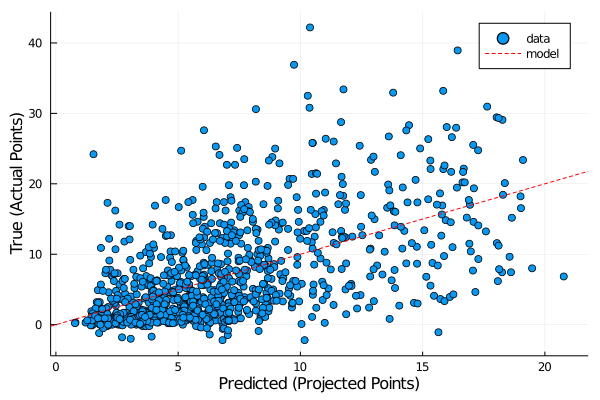

In [12]:
plot_pred_true(test_pred, test_std)

## OLS with GLM package
Use GLM package for OLS

In [13]:
Xtrain_glm = replace(hcat(convert(Matrix, train_real), train_cat_vals), NaN=>0)

41270×37 Array{Float64,2}:
  0.0       0.0  0.0  0.0  0.0  …  1517.34  1.0  0.0  0.0  0.0  0.0
  0.0       0.0  0.0  0.0  0.0     1454.83  0.0  1.0  0.0  0.0  0.0
 49.6853    0.0  0.0  7.0  4.0     1459.72  0.0  0.0  1.0  0.0  0.0
  0.0       0.0  0.0  0.0  0.0     1374.69  0.0  0.0  1.0  0.0  0.0
  0.0       0.0  0.0  0.0  0.0     1654.33  0.0  0.0  1.0  0.0  0.0
  0.0       0.0  0.0  0.0  0.0  …  1623.6   0.0  0.0  1.0  0.0  0.0
  0.0       0.0  0.0  0.0  0.0     1417.32  1.0  0.0  0.0  0.0  0.0
 62.0535    0.0  0.0  8.0  5.0     1624.17  0.0  1.0  0.0  0.0  0.0
  0.0       0.0  0.0  0.0  0.0     1282.91  1.0  0.0  0.0  0.0  0.0
  0.0       0.0  0.0  0.0  0.0     1697.51  1.0  0.0  0.0  0.0  0.0
  0.0       0.0  0.0  0.0  0.0  …  1648.6   0.0  1.0  0.0  0.0  0.0
  0.0       0.0  0.0  0.0  0.0     1421.57  1.0  0.0  0.0  0.0  0.0
 51.0       0.0  0.0  3.0  2.0     1513.61  0.0  0.0  0.0  1.0  0.0
  ⋮                             ⋱                          ⋮    
  0.0       0.0  0.0  0.

Use $\texttt{allowrankdeficient = true}$ to analytically solve some of the issues with multicollinearity.

In [14]:
m2 = lm(Xtrain, train_std, true)

LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,CholeskyPivoted{Float64,Array{Float64,2}}}}:

Coefficients:
──────────────────────────────────────────────────────────────────────────
            Coef.   Std. Error      t  Pr(>|t|)    Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────
x1    0.019868     0.00422008    4.71    <1e-5    0.0115966    0.0281395
x2    1.27812      0.199639      6.40    <1e-9    0.886827     1.66942
x3   -0.297509     0.213702     -1.39    0.1639  -0.716369     0.121351
x4   -0.168151     0.043803     -3.84    0.0001  -0.254006    -0.0822961
x5    0.31357      0.0725019     4.32    <1e-4    0.171464     0.455675
x6    0.112823     0.0294175     3.84    0.0001   0.0551638    0.170482
x7    0.048124     0.00601264    8.00    <1e-14   0.0363391    0.059909
x8    1.30538      0.239973      5.44    <1e-7    0.835025     1.77573
x9   -0.191008     0.0764376    -2.50    0.0125  -0.340827    -0.0411887

In [15]:
Xtest_glm = replace(hcat(convert(Matrix, test_real), test_cat_vals), NaN=>0)
pred_m2_test = predict(m2, Xtest)
test_MSE = MSE(test_std, pred_m2_test)

31.45177859158327

That allows us to calculate OLS with the typical algorithm.

In [16]:
m3 = lm(Xtrain, train_std);

In [17]:
pred_m3 = predict(m3, Xtrain);

In [18]:
# Xtest_glm2 = hcat(Xtest_glm[:,1:93], Xtest_glm[:, 95:128], Xtest_glm[:, 130:184])
pred_m3_test = predict(m3, Xtest)
test_MSE = MSE(test_std, pred_m3_test)

31.451778591583263

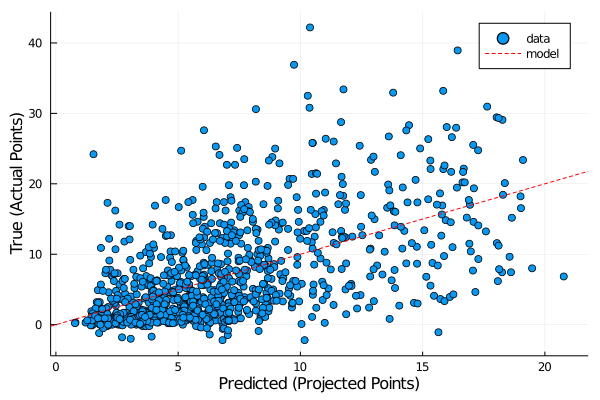

In [19]:
plot_pred_true(pred_m2_test, test_std)
# savefig("ols.png")

# Lasso Regression
## Lasso paths with Lasso.jl

In [20]:
m_lasso = fit(LassoPath, Xtrain, train_std, Normal())

LassoPath (63) solutions for 38 predictors in 2656 iterations):
───────────────────────────────────
               λ    pct_dev  ncoefs
───────────────────────────────────
 [1]  2.81785     0.0             0
 [2]  2.56752     0.0277488       1
 [3]  2.33943     0.0507863       1
 [4]  2.1316      0.0699124       1
 [5]  1.94224     0.0857912       1
 [6]  1.76969     0.10124         2
 [7]  1.61248     0.12354         3
 [8]  1.46923     0.142174        3
 [9]  1.33871     0.157644        3
[10]  1.21978     0.170488        3
[11]  1.11142     0.188173        7
[12]  1.01268     0.210469        6
[13]  0.92272     0.229603        7
[14]  0.840748    0.246206        7
[15]  0.766058    0.260027        8
[16]  0.698004    0.271497        8
[17]  0.635995    0.281019        8
[18]  0.579495    0.288922        8
[19]  0.528014    0.295494        9
[20]  0.481107    0.301067       10
[21]  0.438367    0.30571        10
[22]  0.399423    0.309598       12
[23]  0.36394     0.312849       12


In [21]:
pred_m_lasso_test = predict(m_lasso, Xtest)[:, 81]
test_MSE_lasso = MSE(test_std, pred_m_lasso_test)

LoadError: BoundsError: attempt to access 10319×63 Array{Float64,2} at index [1:10319, 81]

In [22]:
plot_pred_true(pred_m_lasso_test, test_std)
# savefig("lasso.png")

LoadError: UndefVarError: pred_m_lasso_test not defined

In [23]:
# plot(m_lasso; x = m_lasso[:, :logλ])

## Cross-validation procedure to select $\lambda$ for lasso regression

Train lasso model with 10-fold cross validation procedure.

In [24]:
# Xtrain = replace(hcat(convert(Matrix, train_real)), NaN=>0)
# Xtest = replace(hcat(convert(Matrix, test_real)), NaN=>0)

In [31]:
Random.seed!(0)
lasso_cv = fit(LassoModel, Xtrain, train_std; select = MinCVmse(Kfold(41270, 10)), standardize = false, intercept = false);

In [26]:
pred_lasso_cv = predict(lasso_cv, Xtest)

10319-element Array{Float64,1}:
 8.61944875554032
 5.600016463794619
 5.771378335946498
 3.3584562403699034
 2.4936687092943894
 5.417404581189631
 6.656903835652047
 8.057131470570546
 4.618893953868603
 4.389345695013591
 7.445915406190495
 8.114337780134605
 5.668849461777778
 ⋮
 9.346359749888084
 4.4318746683521795
 3.8769147539944906
 3.9671652727354347
 8.761843633670155
 2.0949819120515216
 6.082088229359007
 4.060470414878619
 3.115486252736223
 3.100300832597602
 8.859512546841263
 7.082819883919407

In [27]:
lasso_cv_ppr = fit(LassoModel, Xtrain, train_ppr; select = MinCVmse(Kfold(41270, 10)), standardize = false, intercept = false)
pred_lasso_cv_ppr = predict(lasso_cv_ppr, Xtest)
lasso_cv_half = fit(LassoModel, Xtrain, train_half; select = MinCVmse(Kfold(41270, 10)), standardize = false, intercept = false)
pred_lasso_cv_half = predict(lasso_cv_half, Xtest);

In [28]:
test_MSE_lasso_cv = MSE(test_std, pred_lasso_cv)
test_MSE_lasso_ppr = MSE(test_ppr, pred_lasso_cv_ppr)
test_MSE_lasso_half = MSE(test_half, pred_lasso_cv_half);

@show test_MSE_lasso_cv;
@show test_MSE_lasso_ppr;
@show test_MSE_lasso_half;

test_MSE_lasso_cv = 32.42667351944897
test_MSE_lasso_ppr = 44.5904811376024
test_MSE_lasso_half = 37.66844542948856


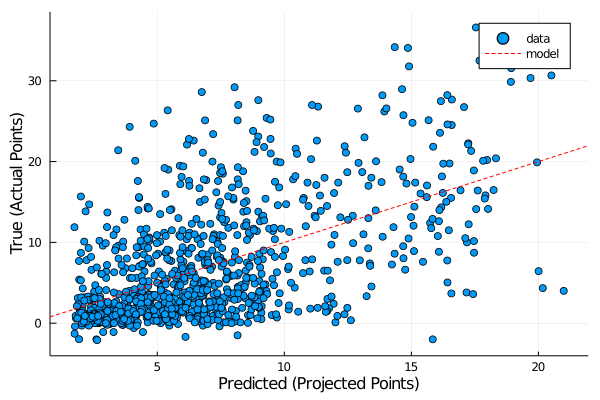

In [53]:
plot_pred_true(pred_lasso_cv, test_std)

Create dataframe of all data.

In [60]:
Xtrain_df = DataFrame(Xtrain)
Xtrain_df.Y = train_std
Xtrain_df;

## Export

Export linear predictions as a .csv for use in projections.

In [70]:
test_pred_all_impute = DataFrame(std_lasso = pred_lasso_cv, ppr_lasso = pred_lasso_cv_ppr, half_lasso = pred_lasso_cv_half)
# CSV.write("$(pwd())\\test_pred_impute.csv", test_pred_all_impute)

"C:\\Users\\darre\\Documents\\_cornell 20-21\\orie 4741\\dream-team\\base models\\test_pred_impute.csv"

In [66]:
df_x = df[:, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]
df_real = df_x[:, labels_real]
df_cats = hcat([onehot(df_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)
df_matrix = replace(hcat(convert(Matrix, df_real), df_cats), NaN=>0)
# df_matrix = replace(convert(Matrix, df_real), NaN => 0)
points_pred_lm = predict(m2, df_matrix)
points_pred_lasso = predict(lasso_cv, df_matrix);

In [67]:
df_points = df[:, 1:4]
df_points.std_lm = points_pred_lm
df_points.std_lasso = points_pred_lasso
df_points.season = df[:, 24]
df_points

,week,Player,Pos,team1,std_lm,std_lasso,season
,Int64,String,String,String,Float64,Float64,Int64
1,15,Thomas Jones,RB,KAN,3.60148,4.05528,2011
2,4,Chris Ivory,RB,NYJ,10.8476,9.92826,2015
3,13,Pierre Garcon,WR,WAS,5.62815,6.18983,2012
4,5,Toby Gerhart,RB,MIN,2.53938,3.47873,2010
5,10,Brian Hoyer,QB,CLE,12.6734,14.0439,2014
6,9,Ben Watson,TE,CLE,5.50912,5.20937,2011
7,17,DeAndre Hopkins,WR,HOU,8.50684,6.9199,2016
8,17,Elijhaa Penny,RB,NYG,1.60779,2.62734,2018
9,12,Willie Snead,WR,NOR,7.19867,7.22473,2016


In [69]:
# CSV.write("..\\projections_2019\\points_proj_impute.csv", df_points)

"..\\projections_2019\\points_proj_impute.csv"